In [83]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, EfficientNetB0, DenseNet121, InceptionV3, Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings(
    "ignore",
    message=r"Your `PyDataset` class should call `super\(\).__init__\(\*\*kwargs\)` in its constructor\."
)

Dataset structure:
['paper', 'rock', 'scissors']
paper: 713 images
rock: 726 images
scissors: 750 images

Total images: 2189


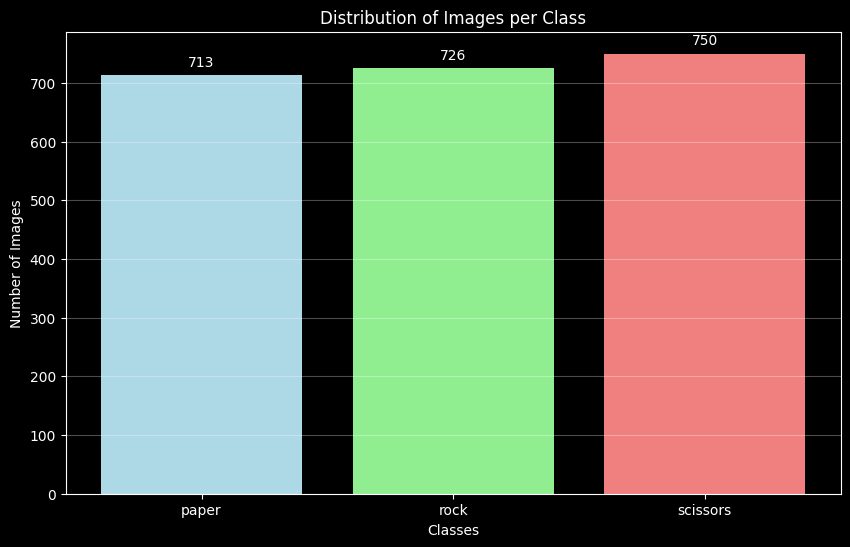

In [84]:
# Dataset configuration
dataset_path = r'../image-dataset/rockpaperscissors/rps-cv-images'
classes = ['paper', 'rock', 'scissors']

print("Dataset structure:")
print(os.listdir(dataset_path))

# Count images in each class
class_counts = {}
total_images = 0

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    if os.path.exists(class_path):
        count = len(os.listdir(class_path))
        class_counts[class_name] = count
        total_images += count
        print(f"{class_name}: {count} images")

print(f"\nTotal images: {total_images}")

# Visualize class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color=['lightblue', 'lightgreen', 'lightcoral'])
plt.title('Distribution of Images per Class')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(class_counts.values()):
    plt.text(i, v + 10, str(v), ha='center', va='bottom')
plt.show()

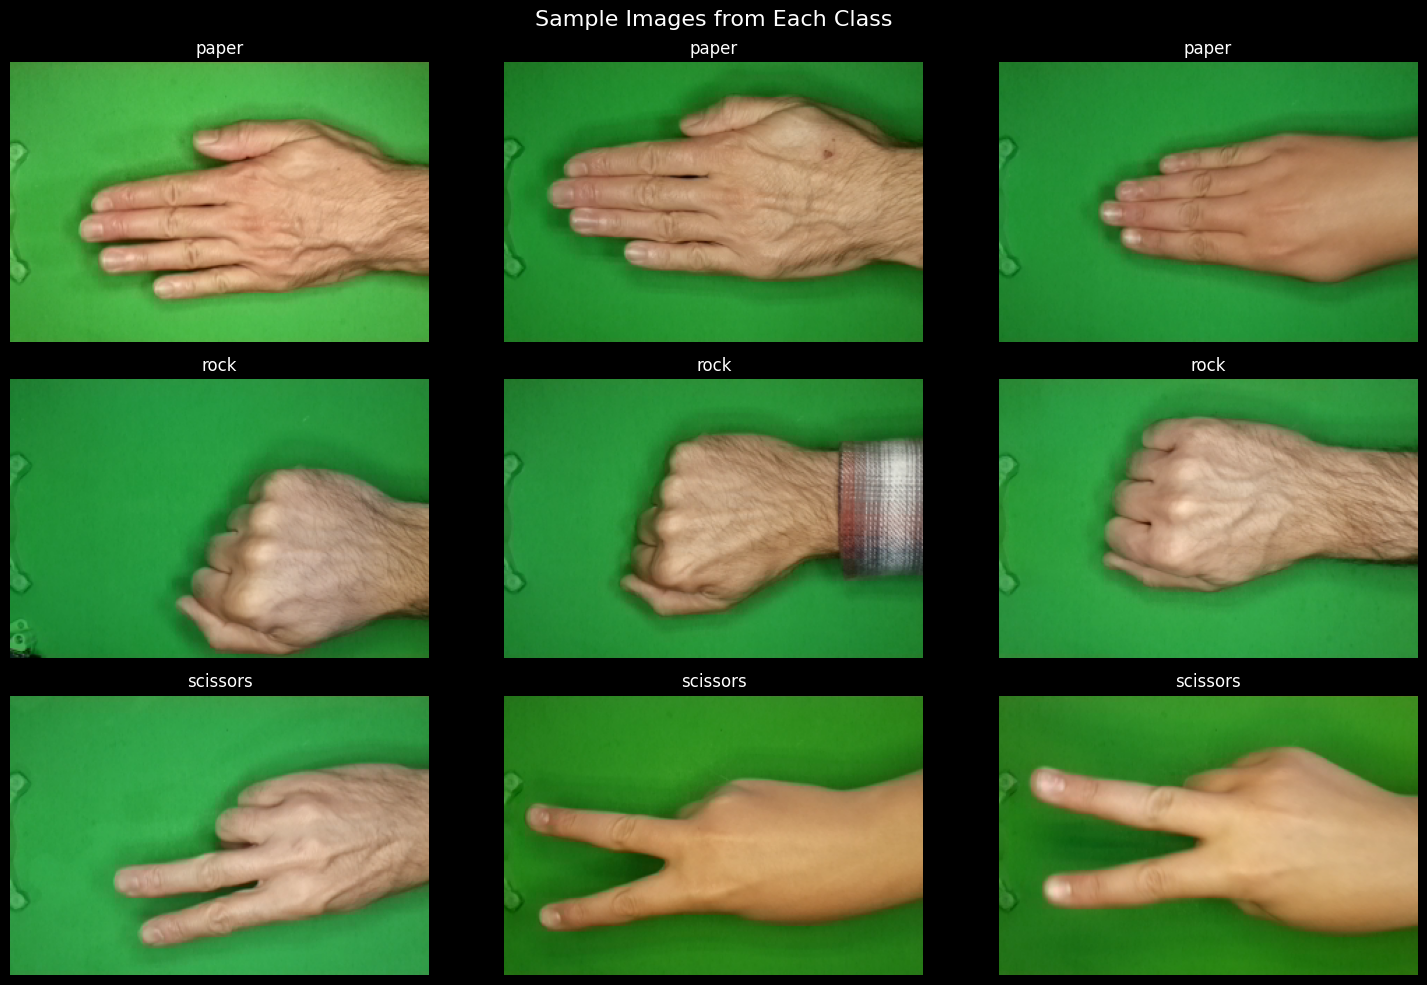

In [85]:
# Display sample images from each class
def display_sample_images(dataset_path, classes, samples_per_class=3):
    fig, axes = plt.subplots(len(classes), samples_per_class, figsize=(15, 10))
    fig.suptitle('Sample Images from Each Class', fontsize=16)
    
    for i, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        image_files = os.listdir(class_path)[:samples_per_class]
        
        for j, image_file in enumerate(image_files):
            image_path = os.path.join(class_path, image_file)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            axes[i, j].imshow(image)
            axes[i, j].set_title(f'{class_name}')
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

display_sample_images(dataset_path, classes)

In [86]:
# Image preprocessing configuration
IMG_HEIGHT, IMG_WIDTH = 224, 224  # Standard size for transfer learning models
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

# Data generators (no augmentation, only rescaling)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT
)

# Validation data generator (no augmentation, only rescaling)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT
)

# Test data generator (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

print("Data generators created successfully")

Data generators created successfully


In [87]:
# Create data generators
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = validation_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

# Print class information
print("\nClasses:", train_generator.class_indices)
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")

Found 1751 images belonging to 3 classes.
Found 437 images belonging to 3 classes.

Classes: {'paper': 0, 'rock': 1, 'scissors': 2}
Training samples: 1751
Validation samples: 437
Found 437 images belonging to 3 classes.

Classes: {'paper': 0, 'rock': 1, 'scissors': 2}
Training samples: 1751
Validation samples: 437


In [88]:
# Custom CNN Model
# Define the preprocessing and augmentation block
preprocessing_block = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomBrightness(factor=0.2),
    tf.keras.layers.RandomContrast(factor=0.2),
    tf.keras.layers.RandomSaturation(factor=0.2),
    tf.keras.layers.RandomHue(factor=0.2),
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
], name="preprocessing_block")

def create_custom_cnn(input_shape=(224, 224, 3), num_classes=3):
    """
    Create a custom CNN with best practices:
    - tf.keras preprocessing layers for augmentation
    - Batch normalization for stable training
    - Dropout for regularization
    - Global average pooling to reduce overfitting
    """
    model = models.Sequential([
        layers.Input(shape=input_shape),
        preprocessing_block,
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Fourth Convolutional Block
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        
        # Dense layers
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create and compile custom CNN
custom_cnn = create_custom_cnn()
custom_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'top_k_categorical_accuracy']
)

print(f"Custom CNN total parameters: {custom_cnn.count_params():,}")

Custom CNN total parameters: 1,309,347



In [89]:
# Transfer Learning Models
def create_transfer_learning_model(base_model_name='VGG16', input_shape=(224, 224, 3), num_classes=3):
    """
    Create transfer learning model with pre-trained weights
    """
    # Select base model
    if base_model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'DenseNet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'Xception':
        base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError(f"Unsupported base model: {base_model_name}. Choose from: 'VGG16', 'ResNet50', 'MobileNetV2', 'EfficientNetB0', 'DenseNet121', 'InceptionV3', 'Xception'")

    # Freeze base model layers initially
    base_model.trainable = False
    
    # Add custom classification head with preprocessing block
    model = models.Sequential([
        layers.Input(shape=input_shape),
        preprocessing_block,
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model, base_model

# Create transfer learning models
print("Creating transfer learning models...")

# VGG16 Model
vgg16_model, vgg16_base = create_transfer_learning_model('VGG16')
vgg16_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# MobileNetV2 Model (lighter and faster)
mobilenet_model, mobilenet_base = create_transfer_learning_model('MobileNetV2')
mobilenet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# ResNet50 Model
resnet_model, resnet_base = create_transfer_learning_model('ResNet50')
resnet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# EfficientNetB0 Model
efficientnet_model, efficientnet_base = create_transfer_learning_model('EfficientNetB0')
efficientnet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# DenseNet121 Model
densenet_model, densenet_base = create_transfer_learning_model('DenseNet121')
densenet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# InceptionV3 Model
inception_model, inception_base = create_transfer_learning_model('InceptionV3')
inception_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Xception Model
xception_model, xception_base = create_transfer_learning_model('Xception')
xception_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Transfer learning models created successfully")
print(f"VGG16 total parameters: {vgg16_model.count_params():,}")
print(f"MobileNetV2 total parameters: {mobilenet_model.count_params():,}")
print(f"ResNet50 total parameters: {resnet_model.count_params():,}")
print(f"EfficientNetB0 total parameters: {efficientnet_model.count_params():,}")
print(f"DenseNet121 total parameters: {densenet_model.count_params():,}")
print(f"InceptionV3 total parameters: {inception_model.count_params():,}")
print(f"Xception total parameters: {xception_model.count_params():,}")

Creating transfer learning models...
Transfer learning models created successfully
VGG16 total parameters: 15,111,491
MobileNetV2 total parameters: 3,051,075
ResNet50 total parameters: 24,777,091
EfficientNetB0 total parameters: 4,842,662
DenseNet121 total parameters: 7,698,499
InceptionV3 total parameters: 22,992,163
Xception total parameters: 22,050,859
Transfer learning models created successfully
VGG16 total parameters: 15,111,491
MobileNetV2 total parameters: 3,051,075
ResNet50 total parameters: 24,777,091
EfficientNetB0 total parameters: 4,842,662
DenseNet121 total parameters: 7,698,499
InceptionV3 total parameters: 22,992,163
Xception total parameters: 22,050,859


In [90]:
# Training Configuration and Callbacks
def create_callbacks(model_name):
    """Create callbacks for training"""
    callbacks = [
        # Early stopping to prevent overfitting
        EarlyStopping(
            monitor='val_accuracy',
            patience=7,
            restore_best_weights=True,
            verbose=1
        ),
        
        # Reduce learning rate when validation accuracy plateaus
        ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.2,
            patience=3,
            min_lr=1e-7,
            verbose=1
        ),
        
        # Save best model
        ModelCheckpoint(
            f'../models/best_{model_name}_model.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]
    return callbacks

# Training parameters
EPOCHS = 20

print("Training configuration:")
print(f"Epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print("Learning rate: 0.001")
print("Callbacks: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint")

Training configuration:
Epochs: 20
Batch size: 32
Learning rate: 0.001
Callbacks: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [ ]:
# Train and fine-tune all models
history_dict = {}
models_dict = {
    'Custom CNN': (custom_cnn, None),
    'VGG16': (vgg16_model, vgg16_base),
    'MobileNetV2': (mobilenet_model, mobilenet_base),
    'ResNet50': (resnet_model, resnet_base),
    'EfficientNetB0': (efficientnet_model, efficientnet_base),
    'DenseNet121': (densenet_model, densenet_base),
    'InceptionV3': (inception_model, inception_base),
    'Xception': (xception_model, xception_base)
}

# Train and fine-tune all models
for model_name, (model, base_model) in models_dict.items():
    print(f"\n===== Training {model_name} =====")
    if model_name == 'Custom CNN':
        history = model.fit(
            train_generator,
            epochs=EPOCHS,
            validation_data=validation_generator,
            callbacks=create_callbacks('custom_cnn'),
            verbose=1
        )
        history_dict[model_name] = history
    else:
        # Initial training with frozen base model
        print(f"Initial training of {model_name}...")
        history_initial = model.fit(
            train_generator,
            epochs=min(10, EPOCHS),
            validation_data=validation_generator,
            callbacks=create_callbacks(f'{model_name}_initial'),
            verbose=1
        )
        # Fine-tuning: Unfreeze some layers and train with lower learning rate
        print(f"Fine-tuning {model_name}...")
        if model_name in ['VGG16', 'ResNet50']:
            for layer in base_model.layers[-4:]:
                layer.trainable = True
        elif model_name in ['MobileNetV2', 'EfficientNetB0']:
            trainable_layers = int(len(base_model.layers) * 0.15)
            for layer in base_model.layers[-trainable_layers:]:
                layer.trainable = True
        else:
            trainable_layers = int(len(base_model.layers) * 0.1)
            for layer in base_model.layers[-trainable_layers:]:
                layer.trainable = True
        model.compile(
            optimizer=Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        history_fine_tune = model.fit(
            train_generator,
            epochs=EPOCHS,
            validation_data=validation_generator,
            callbacks=create_callbacks(f'{model_name}_fine_tuned'),
            verbose=1
        )
        history_dict[model_name] = history_fine_tune

In [ ]:
# Show all training history plots in a grid
num_models = len(history_dict)
cols = 2
rows = math.ceil(num_models / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*8, rows*4))
axes = axes.flatten() if num_models > 1 else [axes]
for idx, (model_name, history) in enumerate(history_dict.items()):
    ax1 = axes[idx]
    ax1.plot(history.history['accuracy'], label='Train Acc')
    ax1.plot(history.history['val_accuracy'], label='Val Acc')
    ax1.set_title(f'{model_name} Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(alpha=0.3)
    # Plot loss in a twin axis
    ax2 = ax1.twinx()
    ax2.plot(history.history['loss'], label='Train Loss', color='tab:orange', linestyle='--')
    ax2.plot(history.history['val_loss'], label='Val Loss', color='tab:red', linestyle='--')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')
for j in range(idx+1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

# Print best validation accuracy for each model
print("\n===== Best Validation Accuracy for Each Model =====")
print(f"{'Model':<18} | {'Best Val Accuracy':>17}")
print('-'*38)
for model_name, history in history_dict.items():
    best_acc = max(history.history['val_accuracy'])
    print(f"{model_name:<18} | {best_acc:>17.4f}")